In [56]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [53]:
import os
import time
import scipy.stats

from astropy.table import Table
from multiprocessing import Process, Queue, Pool

In [54]:
## Inverse transform sample
def sample(uniform_dist, x_interp, size, rng):
    ## uniform_dist is proxy for cdf
    rndm = rng.uniform(size=size)
    idx = [(np.abs(uniform_dist - rndm[ii])).argmin() for ii in range(size)]
    return(x_interp[idx])

## Convert from index in flattened array to 2d index
def find_2d_index(index, nx):
    index = np.asarray(index)
    ix = index % nx
    iy = index // nx
    return(ix, iy)


## type
def prob_type(t, a, t0):
    '''Distribution for galaxy of type t.
    
    Parameters
    ----------
    t : int or array
        Galaxy type(s) to be sampled.
    a : Model parameter.
    t0 : Model parameter.
    
    Returns
    -------
    int or array
    Distribution of probabilities.
    '''
    
    num = t ** a
    den = np.exp(t / t0) ** a
    
    p = num / den
    norm = np.sum(p)
    
    return(p / norm)

## z
def assign_redshifts(t, rng):
    '''Generate a redshift distribution for 
    galaxies based on their type t.
    
    Parameters
    ----------
    t : int or array
        Galaxy type(s) to be sampled.
    
    Returns
    -------
    int or array
    Distribution of probabilities.
    '''
    
    n = len(t)
    z = np.ones_like(t)
    
    rnd = rng.uniform(size=n)
    
    for ii, tt in enumerate(t):
        if tt == 0:
            if rnd[ii] >= 0.2:
                z[ii] = tt
            else:
                z[ii] = tt + 0.02
        if tt == 1:
            if rnd[ii] >= 0.2:
                z[ii] = tt
            else:
                z[ii] = tt - 0.02
        else:
            if rnd[ii] >= 0.4:
                z[ii] = tt
            if tt < 0.02:
                z[ii] = tt + 0.02
            elif tt > 0.98:
                z[ii] = tt - 0.02
            else:
                if (rnd[ii] >= 0.2) and (rnd[ii] < 0.4):
                    z[ii] = tt + 0.02
                else:
                    z[ii] = tt - 0.02   
    return(z)

## F
def feature_likelihood(t, scale, rng):
    return(scipy.stats.norm.rvs(loc=t, scale=scale, random_state=rng))

## delta field
def fftIndgen(n):
    '''Generate grid of k values over which to calculate power spectrum.'''
    a = range(0, int(n/2)+1)
    b = range(1, int(n/2))
    b = reversed(b)
    a = [i for i in a]
    b = [-i for i in b]
    return a + b

def gaussian_random_field(Pk = lambda k : k**-3.0, size = 1024):
    def Pk2(kx, ky):
        if kx == 0 and ky == 0:
            return 0.0
        return np.sqrt(Pk(np.sqrt(kx**2 + ky**2)))
    noise = np.fft.fft2(np.random.normal(size = (size, size)))
    amplitude = np.zeros((size,size))
    for i, kx in enumerate(fftIndgen(size)):
        for j, ky in enumerate(fftIndgen(size)):            
            amplitude[i, j] = Pk2(kx, ky)
    return np.fft.ifft2(noise * amplitude)

def delta_field(nx, nz, rms=2.5):
    delta = np.empty((nx,nx,nz))
    for i in range(nz):
        z_slice = gaussian_random_field(Pk = lambda k: k**-3.0, size=nx).real
        ## set variance = 2.5
        delta[:,:,i] = (z_slice / np.std(z_slice)) * rms
    return(delta)

def get_positions(rho, z_indices, nx, nz, N, rng):
    rho_flat = rho.reshape(nx*nx, 50)
    cdf = np.cumsum(rho_flat, axis=0)
    cdf /= cdf[-1,:]

    unique, counts = np.unique(z_indices, return_counts=True)
    n_subsamples = (counts * 0.05).astype(int)
    
    theta_x = np.empty(N, dtype=int)
    theta_y = np.empty(N, dtype=int)

    for i in range(nz):
        u = rng.uniform(size=counts[i])
        ## this line takes the most time to run
        indices = [np.argmin(np.abs(cdf[:,i] - u[j])) for j in range(counts[i])]
        ix, iy = np.unravel_index(indices, (nx,nx)) ## this doesn't sample in the correct locations...
        galaxies_index = np.argwhere(z_indices == i)
        theta_x[galaxies_index] = ix.reshape(-1,1)
        theta_y[galaxies_index] = iy.reshape(-1,1)
    
    return(theta_x, theta_y)

In [51]:
def setup_bins(nz, nt):
    
    z_bins = np.linspace(0, 1, nz+1)
    z_mdpt = (z_bins[1:] + z_bins[:-1]) / 2
    t_bins = np.linspace(0, 1, nt+1)
    t_mdpt = (t_bins[1:] + t_bins[:-1]) / 2
    
    return(z_bins, z_mdpt, t_bins, t_mdpt)


def interpolate_type_cdf_domain(t_mdpt, t_bins, a, t0, N, rng):
    
    p = prob_type(t_mdpt, a, t0)
    P = np.zeros_like(t_bins)
    P[1:] = np.cumsum(p)
    P /= P[-1] 
    
    u = rng.uniform(size=N)
    return(u, np.interp(u, P, t_bins))
    

def generate_walker(seed, save_dir='./', nz=50, nt=50, nx=1024, N=100000, a=1.5, t0=0.3, sig_F=0.02, rms=2.5):
    
    rng = np.random.RandomState(seed)
    
    ## set up table to store initial type and redshift data
    col_names = ['F', 't', 'z', 'theta_x', 'theta_y', 'z_bin']
    galaxies = Table(data=np.full((N,len(col_names)), 0), names=(col_names))
    
    ## set up bins
    z_bins, z_mdpt, t_bins, t_mdpt = setup_bins(nz, nt)
    
    ## set up type cdf domain for ITS
    u, t_interp = interpolate_type_cdf_domain(t_mdpt, t_bins, a, t0, N, rng)
    
    print('Sampling types...', end='', flush=True)
    galaxies['t'] = sample(u, t_interp, N, rng)
    print('done.')
    print('Sampling redshifts...', end='', flush=True)
    galaxies['z'] = assign_redshifts(galaxies['t'], rng)
    galaxies['z_bin'] = np.digitize(galaxies['z'], z_bins) - 1
    print('done.')
    print('Sampling features...', end='', flush=True)
    galaxies['F'] = feature_likelihood(galaxies['t'], scale=sig_F, rng=rng)
    print('done.')
    print('Generating delta field...', end='', flush=True)
    delta = delta_field(nx, nz, rms=rms)
    rho = np.maximum(0, delta + 1)
    print('done.')
    print('Sample positions based on a 5% subsample of delta field...', 
          end='', flush=True)
    galaxies['theta_x'], galaxies['theta_y'] = get_positions(rho, galaxies['z_bin'], nx, nz, N, rng)
    print('done.')
    
    if save_dir:
        galaxies.write(save_dir+'galaxies_{}.fits'.format(seed), format='fits', overwrite=True)
        np.save(save_dir+'data_{}'.format(seed), [z_bins, z_mdpt, t_bins, t_mdpt, rho])
    
    q.put([z_bins, z_mdpt, t_bins, t_mdpt, rho, galaxies])

In [ ]:
#seeds = np.arange(1,33)
seeds = np.arange(1,9)
    
pool = Pool(processes=os.cpu_count())

results = pool.map(generate_walker, seeds)

pool.close()

Sampling types...Sampling types...Sampling types...Sampling types...Sampling types...Sampling types...Sampling types...Sampling types...

In [46]:
seeds = [22, 33, 44, 55]

start = time.time()

q = Queue()
p1 = Process(target=generate_walker, args=(seeds[0], True, q))
p1.start()
p2 = Process(target=generate_walker, args=(seeds[1], True, q))
p2.start()
p3 = Process(target=generate_walker, args=(seeds[2], True, q))
p3.start()
p4 = Process(target=generate_walker, args=(seeds[3], True, q))
p4.start()

results = []
for i in range(len(seeds)):
    #set block=True to block until we get a result
    results.append(q.get(True))

p1.join()
p2.join()
p3.join()
p4.join()

print('Total time: {}'.format(time.time()-start))

Sampling types...Sampling types...Sampling types...Sampling types...done.
Sampling redshifts...done.
Sampling redshifts...done.
Sampling redshifts...done.
Sampling redshifts...done.
Sampling features...done.
Generating delta field...done.
Sampling features...done.
Generating delta field...done.
Sampling features...done.
Generating delta field...done.
Sampling features...done.
Generating delta field...done.
Sample positions based on a 5% subsample of delta field...done.
Sample positions based on a 5% subsample of delta field...done.
Sample positions based on a 5% subsample of delta field...done.
Sample positions based on a 5% subsample of delta field...done.
done.
done.
done.
Total time: 4530.337233066559


In [9]:
walker_22 = Table.read('old_galaxies_files/galaxies_22.fits', format='fits')
walker_33 = Table.read('old_galaxies_files/galaxies_33.fits', format='fits')
walker_44 = Table.read('old_galaxies_files/galaxies_44.fits', format='fits')
walker_55 = Table.read('old_galaxies_files/galaxies_55.fits', format='fits')

Initial simulation (each walker) consists of 100,000 galaxies. Each chain in the Gibbs sampler then generates 2500 samples. 4 chains x 2500 samples/chain = 10,000 samples.

## Gibbs sampler

In [5]:
!ls

BlackbodySpectrumStudy.ipynb
SOM.ipynb
TPZ.dot
TPZ_dot.png
TPZ_neato.png
bernstein_paper.ipynb
bernstein_paper_scratch.ipynb
bernstein_redshift_inference_paper.ipynb
calculate_errors.ipynb
colors_table.fits
colors_z0005_t200_r25.p
cori
data
decision_tree.ipynb
density_field.png
galaxy_data.pkl
initial_data.fits
mags_z0005_t200_r25.p
old_galaxies_files
photoz.ipynb
pz_DC1.ipynb
redshift_inference_using_hbm.ipynb
rho.npy
rho_22.npy
rho_33.npy
rho_44.npy
rho_55.npy
run_mcmc.py
sampled
sampled_test.fits
sed_blackbody.ipynb
temp


In [7]:
z_bins, z_mdpt, t_bins, t_mdpt = setup_bins(nz=50, nt=50)
initial_data = Table.read('initial_data.fits', format='fits')
rho = np.load('rho.npy')

In [20]:
def run_mcmc(initial_data, seed, z_bins, z_mdpt, t_bins, t_mdpt, rho, sigma=0.02, eps=1e-4, size=100000, n_cycles=5):
    
    rng = np.random.RandomState(seed=seed)
    
    nz = len(z_mdpt)
    nt = len(t_mdpt)
    
    z_samples = np.empty((n_cycles, size), dtype=np.float64)
    t_samples = np.empty((n_cycles, size), dtype=np.float64)
    
    new_z = initial_data['z']
    new_t = initial_data['t']   
        
    for cycle in range(n_cycles):
        
        print('Cycle {} of {}'.format(cycle+1, n_cycles))
    
        ## Calculate probabilities
        h, _, _ = np.histogram2d(new_z, new_t, bins=(z_bins, t_bins))
                    
        h[h == 0] = eps
        alpha = h.flatten()

        ## Generate Dirichlet posterior for probabilities
        ## this producing the same distribution each time, because alpha is different for each iteration...
        dirichlet = scipy.stats.dirichlet.rvs(alpha, random_state=rng, size=1)
        dirichlet = dirichlet.reshape(nz,nt)
        
        ## Sample from posterior
        new_indices = np.empty(size, dtype=int)

        for k in range(size): 
            norm = scipy.stats.norm.pdf(t_mdpt, loc=initial_data['F'][k], scale=sigma) 
            probs = dirichlet * norm #* rho[initial_data['theta_x'][k], initial_data['theta_y'][k]].reshape(-1,1)
            probs /= np.sum(probs)
            new_index = scipy.stats.multinomial.rvs(n=1, p=probs.flatten(), size=1, random_state=rng)
            new_indices[k] = np.argmax(new_index)
                        
        unravel_index = np.unravel_index(new_indices, (nz,nt))
        new_iz, new_it = unravel_index[0], unravel_index[1]
        #new_iz/new_it are the bin indices in the 1d redshift/type bin array
        new_z = scipy.stats.norm.rvs(loc=z_mdpt[new_iz], scale=np.full(len(new_iz), 0.01), random_state=rng)
        new_t = scipy.stats.norm.rvs(loc=t_mdpt[new_it], scale=np.full(len(new_it), 0.01), random_state=rng)
        
        z_samples[cycle] = new_z
        t_samples[cycle] = new_t
    
    return(z_samples, t_samples)

In [37]:
rho.shape

(1024, 1024, 50)

In [36]:
rho[initial_data['theta_x'][0], initial_data['theta_y'][0]]

array([1.14846389e+00, 1.55437801e+00, 3.43085190e+00, 0.00000000e+00,
       0.00000000e+00, 5.62066103e-01, 2.50208463e+00, 0.00000000e+00,
       1.30048027e+00, 3.96757932e+00, 0.00000000e+00, 3.71873134e+00,
       0.00000000e+00, 3.24301515e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.48527685e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.14249111e+00, 3.09927920e+00,
       0.00000000e+00, 0.00000000e+00, 5.36980787e+00, 3.84843894e+00,
       2.20516930e+00, 1.51692608e+00, 3.78299548e-03, 0.00000000e+00,
       2.02180017e+00, 2.48238869e+00, 2.24517965e-01, 0.00000000e+00,
       2.02168883e+00, 2.11661796e-01, 2.01620849e+00, 1.33872482e+00,
       3.07059413e+00, 2.36317480e+00, 0.00000000e+00, 0.00000000e+00,
       3.10598976e-01, 2.75309980e+00, 3.26087895e+00, 0.00000000e+00,
       4.78901211e+00, 3.08581283e+00])

Troubleshooting issue of smaller errors w/clustering data, and errors w/out clustering data aren't big enough
Overplot histograms and see look at bias/variance

In [12]:
sampled_z, sampled_t = run_mcmc(initial_data, 123, z_bins, z_mdpt, t_bins, t_mdpt, rho)

Cycle 1 of 5
Cycle 2 of 5
Cycle 3 of 5
Cycle 4 of 5
Cycle 5 of 5


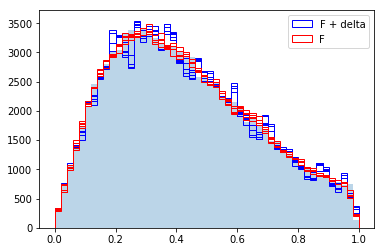

In [45]:
plt.hist(initial_data['z'], bins=z_bins, alpha=0.3)
plt.hist([sampled_z[i] for i in range(5)], color=np.repeat('b', 5), bins=z_bins, histtype='step', label='F + delta')
plt.hist([sampled_z_nc[i] for i in range(5)], color=np.repeat('r', 5), bins=z_bins, histtype='step', label='F')
plt.legend()
plt.show()

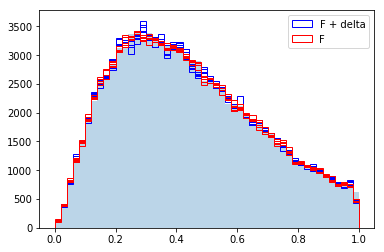

In [47]:
plt.hist(initial_data['t'], bins=t_bins, alpha=0.3)
plt.hist([sampled_t[i] for i in range(5)], color=np.repeat('b', 5), bins=t_bins, histtype='step', label='F + delta')
plt.hist([sampled_t_nc[i] for i in range(5)], color=np.repeat('r', 5), bins=t_bins, histtype='step', label='F')
plt.legend()
plt.show()

In [21]:
sampled_z_nc, sampled_t_nc = run_mcmc(initial_data, 123, z_bins, z_mdpt, t_bins, t_mdpt, rho)

Cycle 1 of 5
Cycle 2 of 5
Cycle 3 of 5
Cycle 4 of 5
Cycle 5 of 5


There is more variance in the F + clustering histograms. I used find_2d_index instead of np.unravel_index() when determining indices in 2d histogram for rho - using unravel would have given incorrect positions in the density field though. But find_2d_index didn't return the correct index values in run_mcmc...there is definitely something wrong in the sampling of rho values...

In [11]:
z_22, t_22 = run_mcmc(walker_22, seeds[0], results[0][0], results[0][1], 
                      results[0][2], results[0][3], results[0][4], size=10000)

NameError: name 'results' is not defined

each chain has 4 walkers
each walker produces 2500 samples
so each chain produces 4 x 2500 = 10000 samples
choose n_cycles based on convergence metric (see gelman & rubin)

so we want to generate 8 chains to simulate a data set of 8 x 10000 galaxies for our fiducial study

In [ ]:
def run_chains(seed_list):
    
    start = time.time()
    
    p = Pool(os.cpu_count())
    p.map(generate_walker, [(seed_list[0], True, q), (seed_list[1], True, q), (seed_list[2], True, q), 
                            (seed_list[3], True, q)])

    results = []
    for i in range(len(seeds)):
        #set block=True to block until we get a result
        results.append(q.get(True))

    p1.join()
    p2.join()
    p3.join()
    p4.join()

    print('Total time: {}'.format(time.time()-start))
    return(results)

In [78]:
z_22.shape

(3, 10000)

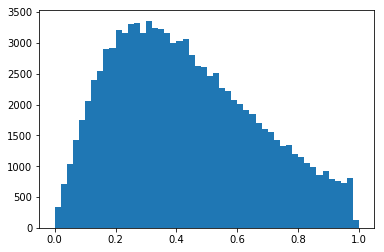

In [72]:
plt.hist(walker_22['z'], bins=results[0][0])
plt.show()

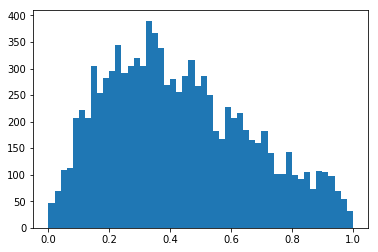

In [77]:
plt.hist(z_22[-1], bins=results[0][0])
plt.show()

In [ ]:
nz = 50
nt = 50

z_bins, z_mdpt, t_bins, t_mdpt = setup_bins(nz, nt)

def get_hist_data(files):
    
    n = len(files)
    
    z = np.empty((n,nz), dtype=int) 
    t = np.empty((n,nt), dtype=int)
    
    for i in range(n):
        table = Table.read(files[i], format='fits')
        z[i], _ = np.histogram(table['z'], bins=z_bins)
        t[i], _ = np.histogram(table['t'], bins=t_bins)
        
    return(z, t, z_percentiles, t_percentiles)